In [1]:
import os
import gc
import re
import abc
import json
import copy
import time
import eli5
import datetime
from numba import jit
from pathlib import Path

from IPython.display import HTML
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
from typing import List, Any

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import random
random.seed(42)
np.random.seed(42)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lightgbm as lgb

from bayes_opt import BayesianOptimization
import shap

from itertools import product
from functools import partial
from joblib import Parallel, delayed

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import linear_model
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error


# Any results you write to the current directory are saved as output.
from time import time
from tqdm.notebook import tqdm
from collections import Counter
from collections import defaultdict
from joblib import Parallel, delayed

pd.set_option('display.max_columns', 1000)
pd.set_option('max_rows', 500)
pd.options.display.precision = 15
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Objective

## Notes

    
## Scores
- baseline
    - score

## Load Data

In [2]:
def read_data(files: list):
    if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
        data_dir_path = '/kaggle/input/data-science-bowl-2019/'
        
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_csv(data_dir_path + file + '.csv')
            print(f'{file} file have {dst_data[file].shape[0]} rows and {dst_data[file].shape[1]} columns.')
    else:
        data_dir_path = '../data/reduced/'
        
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_pickle(data_dir_path + file + '.pkl')
            print(f'{file} file have {dst_data[file].shape[0]} rows and {dst_data[file].shape[1]} columns.')
    return dst_data.values()


# 'sample_submission.csv', 'specs.csv', 'test.csv', 'train_labels.csv', 'train.csv'
raw_train, raw_test, sample_submission = read_data(['train', 'test', 'sample_submission'])

Reading train ....
train file have 11341042 rows and 11 columns.
Reading test ....
test file have 1156414 rows and 11 columns.
Reading sample_submission ....
sample_submission file have 1000 rows and 2 columns.


In [3]:
print(raw_train.shape)
raw_train.head()

(11341042, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


## Creat Feature

In [4]:
# sorted(list(set(raw_train['event_code'].tolist()) & set(raw_test['event_code'].tolist())))
all_event_code = [
    2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083,
    3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035,
    4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010
]
all_title = [
    '12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 
    'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 
    'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 
    'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 
    'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 
    'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 
    'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 
    'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 
    'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 
    'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!'
]
all_type = ['Activity', 'Assessment', 'Clip', 'Game']
all_world = ['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']

assessment_title = [
    'Bird Measurer (Assessment)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 
    'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)'
]

clip_durations = {
    'Welcome to Lost Lagoon!': 19.0, 'Tree Top City - Level 1': 17.0, 'Ordering Spheres': 61.0,
    'Costume Box': 61.0, '12 Monkeys': 109.0, 'Tree Top City - Level 2': 25.0, "Pirate's Tale": 80.0,
    'Treasure Map': 156.0, 'Tree Top City - Level 3': 26.0, 'Rulers': 126.0, 'Magma Peak - Level 1': 20.0,
    'Slop Problem': 60.0, 'Magma Peak - Level 2': 22.0, 'Crystal Caves - Level 1': 18.0, 'Balancing Act': 72.0,
    'Lifting Heavy Things': 118.0, 'Crystal Caves - Level 2': 24.0, 'Honey Cake': 142.0,
    'Crystal Caves - Level 3': 19.0, 'Heavy, Heavier, Heaviest': 61.0
}


assessment_title_map = {l: i for i, l in enumerate(assessment_title)}
all_type_map = {l: i for i, l in enumerate(all_type)}
all_world_map = {l: i for i, l in enumerate(all_world)}

In [5]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        Path(self.save_dir).mkdir(exist_ok=True, parents=True)
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.categoricals = pd.Series()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.pkl"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.pkl"
        self.categoricals_path = Path(self.save_dir) / f"{self.name}_categoricals.pkl"

    def run(self, train_df, test_df=None, log=False):
        self.create_features(train_df, test_df)
        prefix = self.prefix + "_" if self.prefix else ""
        suffix = self.suffix + "_" if self.suffix else ""
        self.train.columns = pd.Index([str(c) for c in self.train.columns])
        self.test.columns = pd.Index([str(c) for c in self.test.columns])
        self.train.columns = prefix + self.train.columns + suffix
        self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df, test_df):
        raise NotImplementedError

    def save(self):
        self.train.to_pickle(str(self.train_path))
        self.test.to_pickle(str(self.test_path))
        self.categoricals.to_pickle(str(self.categoricals_path))

In [6]:
"""
## Abbreviations
- sess -> session, game_session
- ins_id -> installation_id
- acc -> accuracy
- pre -> previous
"""
class PastSessSummary(Feature):
    # accuracy_groupの算出
    def cal_accuracy_group(self, accuracy):
        if accuracy == 0:
            return 0
        elif accuracy == 1:
            return 3
        elif accuracy == 0.5:
            return 2
        else:
            return 1
    
    def calc_dict_stats(self, key_values_dic):
        dst_dict = {}
        for key, val in key_values_dic.items():
            dst_dict.update({
                f'MIN_{key}': np.min(val) if len(val)>0 else 0,
                f'MAX_{key}': np.max(val) if len(val)>0 else 0,
                f'AVG_{key}': np.mean(val) if len(val)>0 else 0,
                f'STD_{key}': np.std(val) if len(val)>0 else 0,
                f'SUM_{key}': np.sum(val) if len(val)>0 else 0,
                f'LAST_{key}': val[-1] if len(val)>0 else -1
            })
        return dst_dict
        
        
    # session単位のデータから特徴量を作成する。
    def get_data(self, ins_id, user_sample, is_test=False):
        all_assessments = []
        # 全過去セッションのcount・sum系特徴量
        past_event_codes = []
        title_count = {i: 0.0 for i in all_title}
        type_count = {i: 0.0 for i in all_type}
        world_count = {i: 0.0 for i in all_world}
        title_sess_time = {f'past_{i}_session_time': [] for i in all_title}
        title_event_count = {f'past_{i}_event_count': [] for i in all_title}
        type_sess_time = {f'past_{i}_session_time': [] for i in all_type}
        type_event_count = {f'past_{i}_event_count': [] for i in all_type}
        # 全過去セッションの各event_code の interval list
        event_code_interval = {f'event_code{i}_interval': [] for i in all_event_code}
        # 過去Assessmentの平均・カウントデータ
        past_all_assessments = []        
        acc_group_count = {f'acc_group_cnt_of_{i}': 0 for i in range(4)}
        avg_acc_group = 0
        avg_acc = 0
        avg_num_correct = 0
        avg_num_incorrect = 0
        avg_num_attempt = 0
        # 直前のセッションの特徴量
        pre_title = 'None'
        pre_world = 'None'
        pre_acc_each_title = {f'previous_acc_of_{t}': -1 for t in assessment_title}
        pre_sess_time_title = {f'pre_session_time_of_{title}': -1 for title in all_title}
        pre_sess_time = -1
        # Game セッションの特徴量
        game_sess_keys = [
            'game_num_correct', 'game_num_incorrect', 'game_num_attempt', 'game_accuracy',
            'game_num_event_count', 'game_sess_time', 'game_round', 'game_sum_misses'
        ]
        game_sess_feats = {k: [] for k in game_sess_keys}
        game_num_correct = []
        game_num_incorrect = []
        game_num_attempt = []
        game_accuracy = []
        game_num_event_count =[]
        game_sess_time = []
        game_round = []
        game_sum_misses = []

        
        # Parse Session Data
        for n_sess, (game_sess, sess) in enumerate(user_sample.groupby('game_session', sort=False)):
            sess_title = sess['title'].iloc[0]
            sess_type = sess['type'].iloc[0]
            sess_world = sess['world'].iloc[0]
            sess_time = sess['game_time'].iloc[-1]
            sess_event_count = sess['event_count'].iloc[-1]
            event_codes = sess['event_code'].tolist()
            
            # Parse Assessment Session 
            if (sess_type == "Assessment") & (is_test or len(sess)>1):
                attempt_code = 4110 if sess_title == "Bird Measurer (Assessment)" else 4100
                all_attempts = sess.query(f"event_code == {attempt_code}")
                
                num_correct = all_attempts["event_data"].str.contains('"correct":true').sum()
                num_incorrect = all_attempts["event_data"].str.contains('"correct":false').sum()

                num_attempt = num_correct + num_incorrect
                accuracy = round(num_correct / num_attempt, 4) if num_attempt != 0 else 0
                accuracy_group = self.cal_accuracy_group(accuracy)
                # Initialize And Create Features
                features = {}
                features.update({
                    'game_session': game_sess,
                    'installation_id': ins_id,
                    'sess_title': sess_title,
                    'accuracy_group': accuracy_group,
                    'num_past_attemmpt_assessment': len(past_all_assessments),
                    'nunique_past_attemmpt_assessment': len(set(past_all_assessments)),
                    'AVG_acc_group': avg_acc_group,
                    'AVG_acc': avg_acc,
                    'AVG_num_correct': avg_num_correct,
                    'AVG_num_incorrect': avg_num_incorrect,
                    'AVG_num_attempt': avg_num_attempt,
                    'pre_title': sess_title,
                    'pre_world': sess_world,
                    'pre_sess_time': pre_sess_time,
                    'total_event_count': len(past_event_codes)
                })
                features.update(Counter(past_event_codes))
                features.update(title_count)
                features.update(type_count)
                features.update(world_count)
                features.update(pre_acc_each_title)
                features.update(acc_group_count)
                features.update(self.calc_dict_stats(title_sess_time))
                features.update(self.calc_dict_stats(title_event_count))
                features.update(self.calc_dict_stats(type_sess_time))
                features.update(self.calc_dict_stats(type_event_count))
#                 features.update(self.calc_dict_stats(event_code_interval))
                features.update(pre_sess_time_title)
                # game features
                features.update(self.calc_dict_stats(game_sess_feats))
                
                if is_test:
                    all_assessments.append(features)
                elif num_attempt > 0:
                    all_assessments.append(features)
                
                # --------------------------------------------------------------------------------
                # Assessment特徴量の更新
                past_all_assessments.append(sess_title)
                pre_acc_each_title[f'previous_acc_of_{sess_title}'] = accuracy
                acc_group_count[f'acc_group_cnt_of_{accuracy_group}'] += 1
                avg_acc_group = (avg_acc_group + accuracy_group) / n_sess if n_sess!=0 else 0
                avg_acc = (avg_acc + accuracy) / n_sess if n_sess!=0 else 0
                avg_num_correct = (avg_num_correct + num_correct) / n_sess if n_sess!=0 else 0
                avg_num_incorrect = (avg_num_incorrect + num_incorrect) / n_sess if n_sess!=0 else 0
                avg_num_attempt = (avg_num_attempt + num_attempt) / n_sess if n_sess!=0 else 0
                
            if sess_type=='Game':
                g_num_correct = sess['event_data'].str.contains('"correct":true').astype(int).sum()
                g_num_incorrect = sess['event_data'].str.contains('"correct":false').astype(int).sum()
                g_num_attempt = g_num_correct + g_num_incorrect
                g_accuracy = g_num_correct / g_num_attempt if g_num_attempt!=0 else -1
                g_round = sess[sess['event_data'].str.contains('round')]['event_data'].str.extract('."round":(\w).').max()[0]
                g_misses = sess[sess['event_data'].str.contains('round')]['event_data'].str.extract('."misses":(\w).').sum()
                g_misses = g_misses[0] if len(g_misses)>0 else 0
                
                game_sess_feats['game_num_correct'].append(g_num_correct)
                game_sess_feats['game_num_incorrect'].append(g_num_incorrect)
                game_sess_feats['game_num_attempt'].append(g_num_attempt)
                game_sess_feats['game_accuracy'].append(g_accuracy)
                game_sess_feats['game_num_event_count'].append(len(event_codes))
                game_sess_feats['game_sess_time'].append(sess_time)
                game_sess_feats['game_round'].append(g_round)
                game_sess_feats['game_sum_misses'].append(g_misses)
            
                    
            # All Session Feature
            past_event_codes.extend(event_codes)
            title_count[sess_title] += 1
            type_count[sess_type] += 1
            world_count[sess_world] += 1
            title_sess_time[f'past_{sess_title}_session_time'].append(sess_time)
            title_event_count[f'past_{sess_title}_event_count'].append(sess_event_count)
            type_sess_time[f'past_{sess_type}_session_time'].append(sess_time)
            type_event_count[f'past_{sess_type}_event_count'].append(sess_event_count)
            pre_title = sess_title
            pre_world = sess_world
            pre_sess_time_title[sess_title] = sess_time
            pre_sess_time = sess_time
#             event_code_interval.update({
#                 f'event_code{k}_interval': event_code_interval[f'event_code{k}_interval'] + [v]
#                 for k, v in zip(event_codes, pd.to_datetime(sess['timestamp']).diff(1).shift(-1).dt.total_seconds().round(4).fillna(0))
#             })

        return all_assessments
        
    
    # installation_idでgroupbyする役割を持ちデータをclass変数に割り当てる。
    def create_features(self, train, test):
        compiled_train = []
        compiled_test = []
        # Feature each by Asessment
        for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False)):
            compiled_train += self.get_data(ins_id, user_sample)
        
        for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False)):
            compiled_test += self.get_data(ins_id, user_sample, is_test=True)
        
        train = pd.DataFrame(compiled_train)
        test = pd.DataFrame(compiled_test) 
        
        categoricals = ['sess_title', 'pre_title', 'pre_world']
        for c in categoricals:
            unique_val = list( set(train[c].tolist()) | set(test[c].tolist()) )
            le = LabelEncoder().fit(unique_val)
            train[c] = le.transform(train[c])
            test[c] = le.transform(test[c])
            
        # Aggritation Feature each by installation_id
        for df in [train, test]:
            df['installation_total_event_count_mean'] = df.groupby(['installation_id'])['total_event_count'].transform('mean')
            for c in categoricals:
                df[f'installation_{c}_nunique'] = df.groupby('installation_id')[c].transform('nunique')
        
            for c in df.columns[df.columns.str.contains('^AVG').fillna(False)]:
                df[f'installation_{c}_mean'] = df.groupby(['installation_id'])[c].transform('mean')
                df[f'installation_{c}_sum'] = df.groupby(['installation_id'])[c].transform('sum')
                df[f'installation_{c}_std'] = df.groupby(['installation_id'])[c].transform('std')
        
        # Set train, test, categoricals
        self.train = train
        self.test = test
        self.categoricals = pd.Series(categoricals)

In [7]:
%%time
PastSessSummary().run(raw_train, raw_test).save()


CPU times: user 9min 8s, sys: 23 s, total: 9min 31s
Wall time: 9min 50s


## Feature Selection

In [8]:
# Load Feature
reduced_train = pd.read_pickle('./features/PastSessSummary_train.pkl')
reduced_test = pd.read_pickle('./features/PastSessSummary_test.pkl').drop_duplicates(subset='installation_id', keep='last')
categoricals = pd.read_pickle('./features/PastSessSummary_categoricals.pkl').tolist()

# Rename Columns For LightGBM
reduced_train.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduced_train.columns]
reduced_test.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduced_test.columns]

In [9]:
print('train_size: ', reduced_train.shape)
print('test_size: ', reduced_test.shape)
reduced_train.head()

train_size:  (17690, 1117)
test_size:  (1000, 1117)


,game_session,installation_id,sess_title,accuracy_group,num_past_attemmpt_assessment,nunique_past_attemmpt_assessment,AVG_acc_group,AVG_acc,AVG_num_correct,AVG_num_incorrect,AVG_num_attempt,pre_title,pre_world,pre_sess_time,total_event_count,2000,3010,4070,3110,4030,4021,4020,4090,4010,2080,2081,2020,2040,2030,3021,3121,2050,3020,3120,2083,2025,4035,4025,4022,12_Monkeys,Air_Show,All_Star_Sorting,Balancing_Act,Bird_Measurer__Assessment_,Bottle_Filler__Activity_,Bubble_Bath,Bug_Measurer__Activity_,Cart_Balancer__Assessment_,Cauldron_Filler__Assessment_,Chest_Sorter__Assessment_,Chicken_Balancer__Activity_,Chow_Time,Costume_Box,Crystal_Caves___Level_1,Crystal_Caves___Level_2,Crystal_Caves___Level_3,Crystals_Rule,Dino_Dive,Dino_Drink,Egg_Dropper__Activity_,Fireworks__Activity_,Flower_Waterer__Activity_,Happy_Camel,Heavy__Heavier__Heaviest,Honey_Cake,Leaf_Leader,Lifting_Heavy_Things,Magma_Peak___Level_1,Magma_Peak___Level_2,Mushroom_Sorter__Assessment_,Ordering_Spheres,Pan_Balance,Pirate_s_Tale,Rulers,Sandcastle_Builder__Activity_,Scrub_A_Dub,Slop_Problem,Treasure_Map,Tree_Top_City___Level_1,Tree_Top_City___Level_2,Tree_Top_City___Level_3,Watering_Hole__Activity_,Welcome_to_Lost_Lagoon_,Activity,Assessment,Clip,Game,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,previous_acc_of_Bird_Measurer__Assessment_,previous_acc_of_Cart_Balancer__Assessment_,previous_acc_of_Cauldron_Filler__Assessment_,previous_acc_of_Chest_Sorter__Assessment_,previous_acc_of_Mushroom_Sorter__Assessment_,acc_group_cnt_of_0,acc_group_cnt_of_1,acc_group_cnt_of_2,acc_group_cnt_of_3,MIN_past_12_Monkeys_session_time,MAX_past_12_Monkeys_session_time,AVG_past_12_Monkeys_session_time,STD_past_12_Monkeys_session_time,SUM_past_12_Monkeys_session_time,LAST_past_12_Monkeys_session_time,MIN_past_Air_Show_session_time,MAX_past_Air_Show_session_time,AVG_past_Air_Show_session_time,STD_past_Air_Show_session_time,SUM_past_Air_Show_session_time,LAST_past_Air_Show_session_time,MIN_past_All_Star_Sorting_session_time,MAX_past_All_Star_Sorting_session_time,AVG_past_All_Star_Sorting_session_time,STD_past_All_Star_Sorting_session_time,SUM_past_All_Star_Sorting_session_time,LAST_past_All_Star_Sorting_session_time,MIN_past_Balancing_Act_session_time,MAX_past_Balancing_Act_session_time,AVG_past_Balancing_Act_session_time,STD_past_Balancing_Act_session_time,SUM_past_Balancing_Act_session_time,LAST_past_Balancing_Act_session_time,MIN_past_Bird_Measurer__Assessment__session_time,MAX_past_Bird_Measurer__Assessment__session_time,AVG_past_Bird_Measurer__Assessment__session_time,STD_past_Bird_Measurer__Assessment__session_time,SUM_past_Bird_Measurer__Assessment__session_time,LAST_past_Bird_Measurer__Assessment__session_time,MIN_past_Bottle_Filler__Activity__session_time,MAX_past_Bottle_Filler__Activity__session_time,AVG_past_Bottle_Filler__Activity__session_time,STD_past_Bottle_Filler__Activity__session_time,SUM_past_Bottle_Filler__Activity__session_time,LAST_past_Bottle_Filler__Activity__session_time,MIN_past_Bubble_Bath_session_time,MAX_past_Bubble_Bath_session_time,AVG_past_Bubble_Bath_session_time,STD_past_Bubble_Bath_session_time,SUM_past_Bubble_Bath_session_time,LAST_past_Bubble_Bath_session_time,MIN_past_Bug_Measurer__Activity__session_time,MAX_past_Bug_Measurer__Activity__session_time,AVG_past_Bug_Measurer__Activity__session_time,STD_past_Bug_Measurer__Activity__session_time,SUM_past_Bug_Measurer__Activity__session_time,LAST_past_Bug_Measurer__Activity__session_time,MIN_past_Cart_Balancer__Assessment__session_time,MAX_past_Cart_Balancer__Assessment__session_time,AVG_past_Cart_Balancer__Assessment__session_time,STD_past_Cart_Balancer__Assessment__session_time,SUM_past_Cart_Balancer__Assessment__session_time,LAST_past_Cart_Balancer__Assessment__session_time,MIN_past_Cauldron_Filler__Assessment__session_time,MAX_past_Cauldron_Filler__Assessment__session_time,AVG_past_Cauldron_Filler__Assessment__session_time,STD_past_Cauldron_Filler__Assessment__session_time,SUM_past_Cauldron_Filler__Assessment__

In [10]:
# Define Feature
features = reduced_train.columns.tolist()
# Reduce Feature
cols_to_drop = []

# 予測に必要ないカラムを除外
cols_to_drop += ['game_session', 'installation_id', 'num_correct', 'num_incorrect', 'accuracy_group', 'accuracy', 'game_time']
# データが無いカラムを除外
cols_to_drop += reduced_train.loc[(reduced_train.sum(axis=1) == 0), (reduced_train.sum(axis=0) == 0)].columns.tolist()

features = [x for x in features if x not in cols_to_drop]
print(f"Num_Feature: {len(features)}")

Num_Feature: 897


In [11]:
# Drop High Correlation
def get_high_corr(df, features, verbose=False):
    drop_cols = []
    counter = 0
    for feat_a in tqdm(features):
        for feat_b in features:
            if feat_a != feat_b and feat_a not in drop_cols and feat_b not in drop_cols:
                corr = np.corrcoef(df[feat_a], df[feat_b])[0, 1]
                if corr > 0.95:
                    counter += 1
                    drop_cols.append(feat_b)
                    if verbose:
                        print(f'{counter}: {feat_a} {feat_b} - Correlation: {corr}')
    return drop_cols

cols_to_drop += get_high_corr(reduced_train, features, verbose=False)


# Remove Feature
categoricals = [x for x in categoricals if x not in (cols_to_drop)]
features = [x for x in features if x not in (cols_to_drop)]
print(f"Num_Feature: {len(features)}")


Num_Feature: 681


### Null importance

In [12]:
## Null importance
## https://qiita.com/KenkenGoda/items/1d6ede5d492d1a9dc3c9
## https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


class Null_Importance():
    def __init__(self, df, features, target, categoricals, n_run, seed=42):
        self.seed = seed
        self.df = df
        self.features = features
        self.target = target
        self.categoricals = categoricals
        self.importance_df = self.fit(n_run)
        
    
    def fit(self, n_run):
        importance_df = pd.DataFrame({'feature': features})
        X = self.df[self.features].values
        y = self.df[self.target].values
        
        train_data = self.convert_dataset(X, y)
        model = self.train_model(train_data)
        importance_df['actual_importance'] = self.get_feature_importace(model)
        
        for i in tqdm(range(n_run)):
            shuffled_y = np.random.permutation(y)
            train_data = self.convert_dataset(X, shuffled_y)
            model = self.train_model(train_data)
            importance_df[f'{i+1}_run_importance'] = self.get_feature_importace(model)
        
        return importance_df
    
    def train_model(self, train_data):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'num_leaves': 32,
            'max_depth': 9,
            'min_data_in_leaf': 20,
            'bagging_fraction': 1.0,
            'early_stopping_round': 10,
            'seed': self.seed
        }
        model = lgb.train(params, train_data, valid_sets=train_data, verbose_eval=0)
        return model
    
    
    def get_feature_importace(self, model):
        return model.feature_importance()
    
    
    def convert_dataset(self, X, y):
        return lgb.Dataset(X, y, categorical_feature=self.categoricals)
    
    
    def get_unimportance_features(self, threshold = 80):
        unimport_features = []
        for feat in self.features:
            feat_df = self.importance_df.query('feature == @feat')
            acutual_val = feat_df['actual_importance'].values
            null_vals = feat_df.iloc[:, 2:].values.ravel()
            typical_null_val = np.percentile(null_vals, threshold)
            if acutual_val <= typical_null_val:
                unimport_features.append(feat)
        return unimport_features
    
    
    def display_importance(self, figsize=(7, 10)):
        imp_df = self.importance_df[['feature', 'actual_importance']].sort_values(by='actual_importance')
        plt.figure(figsize=figsize)
        plt.barh(imp_df['feature'], imp_df['actual_importance'])
        plt.xlabel("Feature Importance")
        plt.show()
    
    
    def display_distributions(self, feature):
        feat_df = self.importance_df.query('feature == @feature')
        acutual_val = feat_df['actual_importance'].values
        null_vals = feat_df.iloc[:, 2:].values.ravel()

        plt.figure()
        ax = plt.hist(null_vals, label='Null Importance', color='tab:blue')
        plt.title(f"Importance of {feature}")
        plt.xlabel(f"Null Importance Distribution for {feature}")
        plt.vlines(x=acutual_val, ymin=0, ymax=np.max(ax[0]), color='red', linewidth=10, label='Real Importance')
        plt.legend()
        plt.show()

In [13]:
# target = 'accuracy_group'
# n_run = 100

# null_imp = Null_Importance(reduced_train, features, target, categoricals=None, n_run=100, seed=42)
# null_imp_drop_cols = null_imp.get_unimportance_features(threshold=80)

In [14]:
# # null importanceの結果を特定のfeatureごとに可視化
# for f in features[:5]:
#     null_imp.display_distributions(f)

# null_imp_drop_cols = null_imp.get_unimportance_features(threshold=80)
# for i in range(0, len(null_imp_drop_cols), 10):
#     temp = null_imp_drop_cols[i:i+7]
#     for t in temp:
#         print(f"'{t}', ", end='')

In [15]:
# null_imp_drop_cols = [
#     'num_past_attemmpt_assessment', 'AVG_acc_group', 'AVG_num_incorrect', 'pre_sess_time', 'total_event_count', '3010', '4070', '4020', '4090', '4010', '2080', '2081', '2020', '2030', '3020', '3120', '2083', '2025', '4035', '4025', '4022', 'Bottle_Filler__Activity_', 'Bubble_Bath', 'Bug_Measurer__Activity_', 'Cart_Balancer__Assessment_', 'Cauldron_Filler__Assessment_', 'Chest_Sorter__Assessment_', 'Chicken_Balancer__Activity_', 'Dino_Drink', 'Egg_Dropper__Activity_', 'Fireworks__Activity_', 'Flower_Waterer__Activity_', 'Happy_Camel', 'Leaf_Leader', 'Mushroom_Sorter__Assessment_', 'Activity', 'Clip', 'Game', 'CRYSTALCAVES', 'MAGMAPEAK', 'TREETOPCITY', 'previous_acc_of_Cart_Balancer__Assessment_', 'LAST_past_12_Monkeys_session_time', 'MAX_past_Air_Show_session_time', 'STD_past_Air_Show_session_time', 'SUM_past_Air_Show_session_time', 'STD_past_All_Star_Sorting_session_time', 'LAST_past_Balancing_Act_session_time', 'MIN_past_Bird_Measurer__Assessment__session_time', 'MIN_past_Bottle_Filler__Activity__session_time', 'MAX_past_Bottle_Filler__Activity__session_time', 'AVG_past_Bottle_Filler__Activity__session_time', 'SUM_past_Bottle_Filler__Activity__session_time', 'MIN_past_Bubble_Bath_session_time', 'MAX_past_Bubble_Bath_session_time', 'AVG_past_Bubble_Bath_session_time', 'MIN_past_Cart_Balancer__Assessment__session_time', 'MAX_past_Cart_Balancer__Assessment__session_time', 'AVG_past_Cart_Balancer__Assessment__session_time', 'STD_past_Cart_Balancer__Assessment__session_time', 'MIN_past_Cauldron_Filler__Assessment__session_time', 'AVG_past_Cauldron_Filler__Assessment__session_time', 'MIN_past_Chest_Sorter__Assessment__session_time', 'MIN_past_Chow_Time_session_time', 'MAX_past_Chow_Time_session_time', 'AVG_past_Chow_Time_session_time', 'STD_past_Chow_Time_session_time', 'SUM_past_Chow_Time_session_time', 'LAST_past_Costume_Box_session_time', 'LAST_past_Crystal_Caves___Level_1_session_time', 'MIN_past_Dino_Dive_session_time', 'MAX_past_Dino_Dive_session_time', 'MIN_past_Dino_Drink_session_time', 'MAX_past_Dino_Drink_session_time', 'AVG_past_Dino_Drink_session_time', 'MAX_past_Egg_Dropper__Activity__session_time', 'STD_past_Egg_Dropper__Activity__session_time', 'STD_past_Fireworks__Activity__session_time', 'MIN_past_Flower_Waterer__Activity__session_time', 'MAX_past_Flower_Waterer__Activity__session_time', 'AVG_past_Flower_Waterer__Activity__session_time', 'STD_past_Flower_Waterer__Activity__session_time', 'SUM_past_Flower_Waterer__Activity__session_time', 'MAX_past_Happy_Camel_session_time', 'LAST_past_Honey_Cake_session_time', 'MIN_past_Leaf_Leader_session_time', 'MAX_past_Leaf_Leader_session_time', 'LAST_past_Lifting_Heavy_Things_session_time', 'LAST_past_Magma_Peak___Level_1_session_time', 'LAST_past_Magma_Peak___Level_2_session_time', 'MIN_past_Mushroom_Sorter__Assessment__session_time', 'LAST_past_Rulers_session_time', 'MIN_past_Sandcastle_Builder__Activity__session_time', 'MAX_past_Sandcastle_Builder__Activity__session_time', 'AVG_past_Sandcastle_Builder__Activity__session_time', 'SUM_past_Sandcastle_Builder__Activity__session_time', 'MIN_past_Scrub_A_Dub_session_time', 'AVG_past_Scrub_A_Dub_session_time', 'LAST_past_Treasure_Map_session_time', 'LAST_past_Tree_Top_City___Level_1_session_time', 'LAST_past_Tree_Top_City___Level_2_session_time', 'LAST_past_Tree_Top_City___Level_3_session_time', 'MIN_past_Watering_Hole__Activity__session_time', 'MAX_past_Watering_Hole__Activity__session_time', 'AVG_past_Watering_Hole__Activity__session_time', 'MAX_past_Air_Show_event_count', 'AVG_past_Air_Show_event_count', 'LAST_past_Air_Show_event_count', 'MIN_past_All_Star_Sorting_event_count', 'AVG_past_All_Star_Sorting_event_count', 'STD_past_All_Star_Sorting_event_count', 'SUM_past_All_Star_Sorting_event_count', 'AVG_past_Bird_Measurer__Assessment__event_count', 'STD_past_Bird_Measurer__Assessment__event_count', 'LAST_past_Bird_Measurer__Assessment__event_count', 'MIN_past_Bottle_Filler__Activity__event_count', 'MAX_past_Bottle_Filler__Activity__event_count', 'AVG_past_Bottle_Filler__Activity__event_count', 'STD_past_Bottle_Filler__Activity__event_count', 'AVG_past_Bubble_Bath_event_count', 'STD_past_Bubble_Bath_event_count', 'SUM_past_Bubble_Bath_event_count', 'LAST_past_Bubble_Bath_event_count', 'MAX_past_Bug_Measurer__Activity__event_count', 'AVG_past_Bug_Measurer__Activity__event_count', 'STD_past_Bug_Measurer__Activity__event_count', 'LAST_past_Cart_Balancer__Assessment__event_count', 'MIN_past_Cauldron_Filler__Assessment__event_count', 'MAX_past_Cauldron_Filler__Assessment__event_count', 'AVG_past_Cauldron_Filler__Assessment__event_count', 'STD_past_Cauldron_Filler__Assessment__event_count', 'LAST_past_Cauldron_Filler__Assessment__event_count', 'MIN_past_Chest_Sorter__Assessment__event_count', 'SUM_past_Chest_Sorter__Assessment__event_count', 'LAST_past_Chest_Sorter__Assessment__event_count', 'MIN_past_Chicken_Balancer__Activity__event_count', 'MAX_past_Chicken_Balancer__Activity__event_count', 'AVG_past_Chicken_Balancer__Activity__event_count', 'STD_past_Chicken_Balancer__Activity__event_count', 'SUM_past_Chicken_Balancer__Activity__event_count', 'STD_past_Chow_Time_event_count', 'SUM_past_Chow_Time_event_count', 'LAST_past_Chow_Time_event_count', 'SUM_past_Costume_Box_event_count', 'SUM_past_Crystal_Caves___Level_1_event_count', 'SUM_past_Crystal_Caves___Level_2_event_count', 'MIN_past_Crystals_Rule_event_count', 'LAST_past_Crystals_Rule_event_count', 'MIN_past_Dino_Dive_event_count', 'MAX_past_Dino_Dive_event_count', 'AVG_past_Dino_Dive_event_count', 'STD_past_Dino_Dive_event_count', 'SUM_past_Dino_Dive_event_count', 'LAST_past_Dino_Dive_event_count', 'STD_past_Dino_Drink_event_count', 'SUM_past_Dino_Drink_event_count', 'LAST_past_Dino_Drink_event_count', 'MIN_past_Egg_Dropper__Activity__event_count', 'MAX_past_Egg_Dropper__Activity__event_count', 'AVG_past_Egg_Dropper__Activity__event_count', 'STD_past_Egg_Dropper__Activity__event_count', 'MAX_past_Fireworks__Activity__event_count', 'AVG_past_Fireworks__Activity__event_count', 'STD_past_Fireworks__Activity__event_count', 'SUM_past_Fireworks__Activity__event_count', 'LAST_past_Fireworks__Activity__event_count', 'MIN_past_Flower_Waterer__Activity__event_count', 'MAX_past_Flower_Waterer__Activity__event_count', 'MIN_past_Happy_Camel_event_count', 'MAX_past_Happy_Camel_event_count', 'AVG_past_Happy_Camel_event_count', 'STD_past_Happy_Camel_event_count', 'SUM_past_Happy_Camel_event_count', 'LAST_past_Happy_Camel_event_count', 'SUM_past_Heavy__Heavier__Heaviest_event_count', 'AVG_past_Leaf_Leader_event_count', 'STD_past_Leaf_Leader_event_count', 'SUM_past_Leaf_Leader_event_count', 'LAST_past_Leaf_Leader_event_count', 'SUM_past_Lifting_Heavy_Things_event_count', 'SUM_past_Magma_Peak___Level_2_event_count', 'MIN_past_Mushroom_Sorter__Assessment__event_count', 'SUM_past_Ordering_Spheres_event_count', 'MIN_past_Pan_Balance_event_count', 'MAX_past_Pan_Balance_event_count', 'AVG_past_Pan_Balance_event_count', 'STD_past_Pan_Balance_event_count', 'SUM_past_Pan_Balance_event_count', 'LAST_past_Pan_Balance_event_count', 'MAX_past_Sandcastle_Builder__Activity__event_count', 'AVG_past_Sandcastle_Builder__Activity__event_count', 'STD_past_Sandcastle_Builder__Activity__event_count', 'SUM_past_Sandcastle_Builder__Activity__event_count', 'LAST_past_Sandcastle_Builder__Activity__event_count', 'MIN_past_Scrub_A_Dub_event_count', 'MAX_past_Scrub_A_Dub_event_count', 'LAST_past_Scrub_A_Dub_event_count', 'SUM_past_Treasure_Map_event_count', 'SUM_past_Tree_Top_City___Level_1_event_count', 'SUM_past_Tree_Top_City___Level_3_event_count', 'MIN_past_Watering_Hole__Activity__event_count', 'MAX_past_Watering_Hole__Activity__event_count', 'AVG_past_Watering_Hole__Activity__event_count', 'MAX_past_Activity_session_time', 'AVG_past_Activity_session_time', 'STD_past_Activity_session_time', 'SUM_past_Activity_session_time', 'LAST_past_Activity_session_time', 'MIN_past_Assessment_session_time', 'AVG_past_Assessment_session_time', 'MAX_past_Game_session_time', 'AVG_past_Game_session_time', 'STD_past_Game_session_time', 'SUM_past_Game_session_time', 'LAST_past_Game_session_time', 'MIN_past_Activity_event_count', 'MAX_past_Activity_event_count', 'LAST_past_Activity_event_count', 'MIN_past_Assessment_event_count', 'MAX_past_Assessment_event_count', 'AVG_past_Assessment_event_count', 'STD_past_Assessment_event_count', 'LAST_past_Assessment_event_count', 'MIN_past_Game_event_count', 'LAST_past_Game_event_count', 'pre_session_time_of_12_Monkeys', 'pre_session_time_of_Air_Show', 'pre_session_time_of_All_Star_Sorting', 'pre_session_time_of_Balancing_Act', 'pre_session_time_of_Bird_Measurer__Assessment_', 'pre_session_time_of_Bottle_Filler__Activity_', 'pre_session_time_of_Cauldron_Filler__Assessment_', 'pre_session_time_of_Chest_Sorter__Assessment_', 'pre_session_time_of_Chicken_Balancer__Activity_', 'pre_session_time_of_Chow_Time', 'pre_session_time_of_Costume_Box', 'pre_session_time_of_Crystal_Caves___Level_1', 'pre_session_time_of_Crystal_Caves___Level_2', 'pre_session_time_of_Dino_Drink', 'pre_session_time_of_Egg_Dropper__Activity_', 'pre_session_time_of_Fireworks__Activity_', 'pre_session_time_of_Flower_Waterer__Activity_', 'pre_session_time_of_Happy_Camel', 'pre_session_time_of_Heavy__Heavier__Heaviest', 'pre_session_time_of_Honey_Cake', 'pre_session_time_of_Magma_Peak___Level_2', 'pre_session_time_of_Mushroom_Sorter__Assessment_', 'pre_session_time_of_Ordering_Spheres', 'pre_session_time_of_Pan_Balance', 'pre_session_time_of_Pirate_s_Tale', 'pre_session_time_of_Rulers', 'pre_session_time_of_Sandcastle_Builder__Activity_', 'pre_session_time_of_Tree_Top_City___Level_1', 'pre_session_time_of_Tree_Top_City___Level_2', 'pre_session_time_of_Tree_Top_City___Level_3', 'pre_session_time_of_Watering_Hole__Activity_', 'pre_session_time_of_Welcome_to_Lost_Lagoon_', 'MIN_game_num_correct', 'MAX_game_num_correct', 'LAST_game_num_correct', 'MIN_game_num_incorrect', 'MAX_game_num_incorrect', 'AVG_game_num_incorrect', 'STD_game_num_incorrect', 'SUM_game_num_incorrect', 'LAST_game_num_incorrect', 'SUM_game_accuracy', 'MIN_game_round', 'MAX_game_round', 'AVG_game_round', 'STD_game_round', 'LAST_game_round', 'LAST_game_sum_misses', '2010', '2060', '2070', '4110', '5000', '5010', '4031', '2075', '4230', '4235', '4050', 'installation_total_event_count_mean', 'installation_sess_title_nunique', 'installation_pre_world_nunique', 'installation_AVG_past_Air_Show_session_time_std', 'installation_AVG_past_All_Star_Sorting_session_time_mean', 'installation_AVG_past_All_Star_Sorting_session_time_std', 'installation_AVG_past_Bird_Measurer__Assessment__session_time_mean', 'installation_AVG_past_Bird_Measurer__Assessment__session_time_sum', 'installation_AVG_past_Bottle_Filler__Activity__session_time_mean', 'installation_AVG_past_Bottle_Filler__Activity__session_time_sum', 'installation_AVG_past_Bug_Measurer__Activity__session_time_mean', 'installation_AVG_past_Bug_Measurer__Activity__session_time_sum', 'installation_AVG_past_Bug_Measurer__Activity__session_time_std', 'installation_AVG_past_Cauldron_Filler__Assessment__session_time_sum', 'installation_AVG_past_Chest_Sorter__Assessment__session_time_mean', 'installation_AVG_past_Chest_Sorter__Assessment__session_time_sum', 'installation_AVG_past_Chicken_Balancer__Activity__session_time_mean', 'installation_AVG_past_Chow_Time_session_time_sum', 'installation_AVG_past_Chow_Time_session_time_std', 'installation_AVG_past_Crystals_Rule_session_time_mean', 'installation_AVG_past_Crystals_Rule_session_time_sum', 'installation_AVG_past_Crystals_Rule_session_time_std', 'installation_AVG_past_Dino_Dive_session_time_mean', 'installation_AVG_past_Dino_Dive_session_time_sum', 'installation_AVG_past_Egg_Dropper__Activity__session_time_std', 'installation_AVG_past_Fireworks__Activity__session_time_mean', 'installation_AVG_past_Fireworks__Activity__session_time_sum', 'installation_AVG_past_Fireworks__Activity__session_time_std', 'installation_AVG_past_Flower_Waterer__Activity__session_time_mean', 'installation_AVG_past_Flower_Waterer__Activity__session_time_sum', 'installation_AVG_past_Flower_Waterer__Activity__session_time_std', 'installation_AVG_past_Leaf_Leader_session_time_std', 'installation_AVG_past_Mushroom_Sorter__Assessment__session_time_mean', 'installation_AVG_past_Pan_Balance_session_time_mean', 'installation_AVG_past_Pan_Balance_session_time_sum', 'installation_AVG_past_Pan_Balance_session_time_std', 'installation_AVG_past_Sandcastle_Builder__Activity__session_time_mean', 'installation_AVG_past_Sandcastle_Builder__Activity__session_time_sum', 'installation_AVG_past_Scrub_A_Dub_session_time_std', 'installation_AVG_past_Watering_Hole__Activity__session_time_sum', 'installation_AVG_past_Watering_Hole__Activity__session_time_std', 'installation_AVG_past_12_Monkeys_event_count_mean', 'installation_AVG_past_12_Monkeys_event_count_sum', 'installation_AVG_past_12_Monkeys_event_count_std', 'installation_AVG_past_Air_Show_event_count_mean', 'installation_AVG_past_All_Star_Sorting_event_count_sum', 'installation_AVG_past_All_Star_Sorting_event_count_std', 'installation_AVG_past_Balancing_Act_event_count_mean', 'installation_AVG_past_Bird_Measurer__Assessment__event_count_mean', 'installation_AVG_past_Bird_Measurer__Assessment__event_count_sum', 'installation_AVG_past_Bottle_Filler__Activity__event_count_mean', 'installation_AVG_past_Bottle_Filler__Activity__event_count_sum', 'installation_AVG_past_Bubble_Bath_event_count_std', 'installation_AVG_past_Bug_Measurer__Activity__event_count_mean', 'installation_AVG_past_Bug_Measurer__Activity__event_count_std', 'installation_AVG_past_Cart_Balancer__Assessment__event_count_sum', 'installation_AVG_past_Cauldron_Filler__Assessment__event_count_sum', 'installation_AVG_past_Chest_Sorter__Assessment__event_count_mean', 'installation_AVG_past_Chicken_Balancer__Activity__event_count_mean', 'installation_AVG_past_Chow_Time_event_count_sum', 'installation_AVG_past_Chow_Time_event_count_std', 'installation_AVG_past_Costume_Box_event_count_mean', 'installation_AVG_past_Costume_Box_event_count_sum', 'installation_AVG_past_Crystal_Caves___Level_1_event_count_mean', 'installation_AVG_past_Crystal_Caves___Level_1_event_count_sum', 'installation_AVG_past_Crystal_Caves___Level_1_event_count_std', 'installation_AVG_past_Crystal_Caves___Level_3_event_count_std', 'installation_AVG_past_Crystals_Rule_event_count_mean', 'installation_AVG_past_Crystals_Rule_event_count_sum', 'installation_AVG_past_Crystals_Rule_event_count_std', 'installation_AVG_past_Dino_Dive_event_count_mean', 'installation_AVG_past_Dino_Dive_event_count_sum', 'installation_AVG_past_Dino_Dive_event_count_std', 'installation_AVG_past_Egg_Dropper__Activity__event_count_mean', 'installation_AVG_past_Egg_Dropper__Activity__event_count_sum', 'installation_AVG_past_Egg_Dropper__Activity__event_count_std', 'installation_AVG_past_Fireworks__Activity__event_count_mean', 'installation_AVG_past_Fireworks__Activity__event_count_sum', 'installation_AVG_past_Fireworks__Activity__event_count_std', 'installation_AVG_past_Flower_Waterer__Activity__event_count_mean', 'installation_AVG_past_Happy_Camel_event_count_sum', 'installation_AVG_past_Happy_Camel_event_count_std', 'installation_AVG_past_Heavy__Heavier__Heaviest_event_count_mean', 'installation_AVG_past_Heavy__Heavier__Heaviest_event_count_std', 'installation_AVG_past_Honey_Cake_event_count_mean', 'installation_AVG_past_Honey_Cake_event_count_sum', 'installation_AVG_past_Honey_Cake_event_count_std', 'installation_AVG_past_Lifting_Heavy_Things_event_count_mean', 'installation_AVG_past_Lifting_Heavy_Things_event_count_sum', 'installation_AVG_past_Lifting_Heavy_Things_event_count_std', 'installation_AVG_past_Magma_Peak___Level_1_event_count_mean', 'installation_AVG_past_Magma_Peak___Level_1_event_count_std', 'installation_AVG_past_Magma_Peak___Level_2_event_count_mean', 'installation_AVG_past_Magma_Peak___Level_2_event_count_sum', 'installation_AVG_past_Ordering_Spheres_event_count_sum', 'installation_AVG_past_Ordering_Spheres_event_count_std', 'installation_AVG_past_Pan_Balance_event_count_mean', 'installation_AVG_past_Pan_Balance_event_count_sum', 'installation_AVG_past_Pan_Balance_event_count_std', 'installation_AVG_past_Pirate_s_Tale_event_count_mean', 'installation_AVG_past_Pirate_s_Tale_event_count_sum', 'installation_AVG_past_Sandcastle_Builder__Activity__event_count_sum', 'installation_AVG_past_Sandcastle_Builder__Activity__event_count_std', 'installation_AVG_past_Scrub_A_Dub_event_count_mean', 'installation_AVG_past_Scrub_A_Dub_event_count_sum', 'installation_AVG_past_Scrub_A_Dub_event_count_std', 'installation_AVG_past_Slop_Problem_event_count_mean', 'installation_AVG_past_Slop_Problem_event_count_std', 'installation_AVG_past_Tree_Top_City___Level_1_event_count_std', 'installation_AVG_past_Tree_Top_City___Level_2_event_count_mean', 'installation_AVG_past_Tree_Top_City___Level_2_event_count_std', 'installation_AVG_past_Tree_Top_City___Level_3_event_count_mean', 'installation_AVG_past_Tree_Top_City___Level_3_event_count_std', 'installation_AVG_past_Watering_Hole__Activity__event_count_mean', 'installation_AVG_past_Watering_Hole__Activity__event_count_sum', 'installation_AVG_past_Activity_session_time_sum', 'installation_AVG_past_Activity_session_time_std', 'installation_AVG_past_Assessment_session_time_mean', 'installation_AVG_past_Assessment_session_time_sum', 'installation_AVG_past_Assessment_session_time_std', 'installation_AVG_past_Game_session_time_mean', 'installation_AVG_past_Game_session_time_sum', 'installation_AVG_past_Activity_event_count_std', 'installation_AVG_past_Assessment_event_count_std', 'installation_AVG_past_Clip_event_count_std', 'installation_AVG_past_Game_event_count_mean', 'installation_AVG_past_Game_event_count_sum', 'installation_AVG_past_Game_event_count_std', 'installation_AVG_game_num_correct_mean', 'installation_AVG_game_num_incorrect_std', 'installation_AVG_game_num_attempt_std', 'installation_AVG_game_accuracy_sum', 'installation_AVG_game_accuracy_std', 'installation_AVG_game_num_event_count_std', 'installation_AVG_game_sess_time_std', 'installation_AVG_game_round_mean'
# ]

# cols_to_drop += null_imp_drop_cols

# features = [x for x in features if x not in (cols_to_drop)]
# print(f"Num_Feature: {len(features)}")

### Adversarial Model

In [16]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

class AdValModel():
    
    def __init__(self, train, test, feature, seed=42):
        all_data = self.set_all_data(train, test)
        self.feature = feature
        self.seed = seed
        self.imp_df = None
        self.fit(all_data, feature)
        pass
    
    
    def set_all_data(self, train, test):
        train['is_test'] = 0
        test['is_test'] = 1
        return pd.concat([train, test], axis=0)
    
    
    def fit(self, all_data, feature):
        X = all_data[feature]
        y = all_data['is_test']
        
        # TODO: ここでtrain_test_splitをしてもいいかもしれない。
        X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting': 'gbdt',
            'num_iterations': 100,
            'learning_rate': 0.3,
            'num_leaves': 32,
            'max_depth': 5,
            'min_data_in_leaf': 20,
            'bagging_fraction': 1.0,
            'seed': self.seed
        }

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        models = []
        auc_scores = []
        for train_index, valid_index in cv.split(X, y):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

            train_data = lgb.Dataset(X_train, y_train)
            valid_data = lgb.Dataset(X_valid, y_valid)

            model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=0, early_stopping_rounds=10)
            models.append(model)
            
        importances = [models[i].feature_importance() for i in range(len(models))]
        imp_df = pd.DataFrame(importances, columns=feature, index=[f'model_{i}' for i in range(len(models))]).T
        imp_df['AVG_importance'] = imp_df.mean(axis=1)
        
        self.imp_df = imp_df.sort_values(by='AVG_importance')
        self.scores = [roc_auc_score(y_test, m.predict(X_test)) for m in models]
        
        
        
    def plot_importance(self, figsize=(7, 10)):
        self.imp_df['AVG_importance'].plot.barh(figsize=figsize)
        plt.xlabel("Feature Importance")
        plt.show()
        
    
    def get_importance_feature(self, max_num=5):
        if max_num is None:
            max_num = len(self.feature)
        return self.imp_df.index[-max_num:].tolist()

In [17]:
# adval_cols = []
# adval_cols += ['MIN_past_Bird_Measurer__Assessment__event_count', 'installation_AVG_num_incorrect_mean', 'installation_AVG_past_Game_session_time_std', '4045', 'installation_AVG_past_Activity_event_count_mean', 'MAX_past_Cauldron_Filler__Assessment__session_time', 'MIN_past_Fireworks__Activity__session_time', 'installation_AVG_game_num_correct_std', 'Chow_Time', 'installation_AVG_past_Egg_Dropper__Activity__session_time_sum', 'installation_AVG_acc_group_sum', 'installation_AVG_past_Mushroom_Sorter__Assessment__event_count_std', 'MAX_past_Cart_Balancer__Assessment__event_count', 'AVG_game_accuracy', 'installation_AVG_past_Bird_Measurer__Assessment__session_time_std', 'installation_AVG_past_Air_Show_event_count_std', 'MIN_past_Fireworks__Activity__event_count', 'MIN_past_Leaf_Leader_event_count', 'installation_AVG_past_Cart_Balancer__Assessment__session_time_std', 'AVG_past_Game_event_count', 'installation_AVG_past_Activity_session_time_mean', 'installation_AVG_past_Cauldron_Filler__Assessment__event_count_std', 'MIN_past_Sandcastle_Builder__Activity__event_count', 'installation_AVG_past_Sandcastle_Builder__Activity__event_count_mean', 'installation_AVG_past_Mushroom_Sorter__Assessment__event_count_mean', 'installation_AVG_game_num_incorrect_sum', 'installation_AVG_past_Cauldron_Filler__Assessment__session_time_mean', 'installation_AVG_past_Cart_Balancer__Assessment__session_time_sum', 'STD_past_Game_event_count', 'installation_AVG_game_num_incorrect_mean', '4220', 'installation_AVG_acc_group_std', 'installation_AVG_past_Chest_Sorter__Assessment__event_count_sum', 'installation_AVG_game_round_std', 'STD_game_accuracy', 'installation_AVG_past_Mushroom_Sorter__Assessment__event_count_sum', 'installation_AVG_past_Flower_Waterer__Activity__event_count_std', '4021', '4100', 'installation_AVG_game_accuracy_mean', 'MIN_past_Activity_session_time', '4040', '2000', 'installation_AVG_acc_group_mean', 'LAST_past_Assessment_session_time', '3110', '4030', 'installation_AVG_num_attempt_std', 'installation_AVG_past_Activity_event_count_sum', 'installation_AVG_past_Assessment_event_count_mean']
# # cols_to_drop += adval_cols
# # features = [x for x in features if x not in (cols_to_drop)]

# adval_model = AdValModel(reduced_train, reduced_test, [x for x in features if x not in (adval_cols)], seed=99)
# print(f'mean: {np.mean(adval_model.scores)}\nstd: {np.std(adval_model.scores)}')
# adval_model.get_importance_feature(50)

In [18]:
# Remove Feature
categoricals = [x for x in categoricals if x not in (cols_to_drop)]
features = [x for x in features if x not in (cols_to_drop)]

print(f"Num_Feature: {len(features)}")

Num_Feature: 681


## Training Model

In [19]:
@jit
def qwk3(a1, a2, num_class=4):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((num_class, ))
    hist2 = np.zeros((num_class, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(num_class):
        for j in range(num_class):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]
    return 1 - o / e

In [20]:
class OptimizedRounder(object):
    def __init__(self, num_class=4):
        self.coef_ = 0
        self.initial_coef = [i for i in np.arange(1, (num_class+1)/2, 0.5)]
        self.labels = [i for i in range(num_class)]
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=self.labels)
        return -qwk3(y, preds)
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = self.initial_coef
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X):
        coef = self.coefficients()
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=self.labels)
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [21]:
@jit
def lgb_reg_qwk(y_pred:np.ndarray, data:lgb.Dataset):
    y_true = data.get_label()

    OptR = OptimizedRounder(num_class=4)
    OptR.fit(y_pred, y_true)
    y_pred = OptR.predict(y_pred).astype(int)
    # name, result, is_higher_better
    return "qwk", qwk3(y_true, y_pred), True

@jit
def lgb_regression_rmse(y_pred:np.ndarray, data:lgb.Dataset):
    y_true = data.get_label()
    return "rmse", np.sqrt(mean_squared_error(y_true, y_pred)), False

@jit
def lgb_weighted_rmse(y_pred:np.ndarray, data:lgb.Dataset):
    y_true = data.get_label()
    weight = data.get_weight()
    return "rmse", np.sqrt(mean_squared_error(y_true, y_pred, sample_weight=weight)), False

In [22]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], 
                 n_splits=5, cv_method='StratifiedKFold', verbose=True, ps={}, custom_eval=None, weight=None):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.groups = 'installation_id'
        self.cv = self.get_cv(cv_method)
        self.verbose = verbose
        self.params = self.set_params(ps)
        self.custom_eval = custom_eval
        self.weight = weight
        self.oof_pred, self.y_pred, self.score, self.models = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self, cv_method):
        method = cv_method
        if method=='StratifiedKFold':
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
            return cv.split(self.train_df, self.train_df[self.target])
        elif method=='GroupKFold':
            cv = GroupKFold(n_splits=self.n_splits)
            return cv.split(self.train_df, self.train_df[self.target], self.train_df[self.groups])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        models = []
        
        for fold, (train_idx, valid_idx) in enumerate(self.cv):
            x_train, y_train = self.train_df[self.features].iloc[train_idx], self.train_df[self.target][train_idx]
            x_valid, y_valid = self.train_df[self.features].iloc[valid_idx], self.train_df[self.target][valid_idx]
            
            train_set, valid_set = self.convert_dataset(x_train, y_train, x_valid, y_valid)
            
            # additonal process, Weight validation data only
            if self.weight is not None:
                valid_set = self.set_weight(valid_set, self.weight[valid_idx])
                
            model = self.train_model(train_set, valid_set)
            models.append(model)
            
            conv_x_val = self.convert_x(x_valid)
            oof_pred[valid_idx] = model.predict(conv_x_val).reshape(oof_pred[valid_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print(f'Partial score of fold {fold} is: {qwk3(y_valid, oof_pred[valid_idx])}\n')
            
        loss_score = qwk3(self.train_df[self.target], oof_pred)
        if self.verbose:
            print(f'\nOur oof cohen kappa score is: {loss_score}\n')
            
        return oof_pred, y_pred, loss_score, models

In [23]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity, feval=self.custom_eval)
        
    def convert_dataset(self, x_train, y_train, x_valid, y_valid):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        valid_set = lgb.Dataset(x_valid, y_valid, categorical_feature=self.categoricals)
        return train_set, valid_set
    
    def set_weight(self, data, weight):
        return data.set_weight(weight)
        
    def get_params(self):
        params = {
            'n_estimators':5000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'feature_fraction': 0.8,
            'max_depth': 7,
            'num_leaves': 2**4,
            'min_data_in_leaf': 50,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            "n_jobs": -1,
            'early_stopping_round': 100
        }
        return params
                                                                        
    def set_params(self, ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params    
    
    def get_feature_importance(self, models):
        feature_importance = pd.DataFrame(
            [model.feature_importance() for model in models],
            columns=models[0].feature_name()
        ).T

        feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
        feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
        feature_importance.sort_values(by='Agerage_Importance', inplace=True)
        return feature_importance
    
    def plot_importance(self, models, max_num_features=50, figsize=(12, 15)):
        feature_importance = self.get_feature_importance(models)
        plt.figure(figsize=figsize)
        
        feature_importance[-max_num_features:].plot(
            kind='barh', title='Feature importance', figsize=figsize,
            y='Agerage_Importance', xerr='importance_std',
            grid=True, align="center"
        )
        plt.legend()
        plt.show()

In [24]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals,ps=params)
    print('kappa: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 3),
    'learning_rate': (0.025, 0.4),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (1, 5),
    'lambda_l2': (1, 5),
    'max_depth': (15, 17),
}

params={}

if False and os.path.exists('/kaggle/input/data-science-bowl-2019/'):
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
        
    params = LGB_BO.max['params']
    print('\n', LGB_BO.max['params'])

In [25]:
# GroupK CV, optimized QWK
# lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params, 
#                       cv_method='GroupKFold', custom_eval=lgb_reg_qwk)

# GroupK CV, weighted rmse
# weight = (1 / (reduced_train.groupby('installation_id')['game_session'].transform('nunique')+1)).values
weight = (1 / (reduced_train.groupby('installation_id')['game_session'].transform('cumcount')+1)).values
lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params, 
                      cv_method='GroupKFold', custom_eval=lgb_weighted_rmse, weight=weight)

# lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params,
#                       custom_eval=lgb_reg_qwk)
# lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params, custom_eval=lgb_reg_qwk, weights=weights)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.895014	training's rmse: 0.895014	valid_1's rmse: 0.923692	valid_1's rmse: 0.923692
[200]	training's rmse: 0.84657	training's rmse: 0.84657	valid_1's rmse: 0.899608	valid_1's rmse: 0.899608
[300]	training's rmse: 0.815107	training's rmse: 0.815107	valid_1's rmse: 0.894111	valid_1's rmse: 0.894111
[400]	training's rmse: 0.789329	training's rmse: 0.789329	valid_1's rmse: 0.890221	valid_1's rmse: 0.890221
[500]	training's rmse: 0.767384	training's rmse: 0.767384	valid_1's rmse: 0.889476	valid_1's rmse: 0.889476
[600]	training's rmse: 0.747191	training's rmse: 0.747191	valid_1's rmse: 0.888044	valid_1's rmse: 0.888044
[700]	training's rmse: 0.728535	training's rmse: 0.728535	valid_1's rmse: 0.887709	valid_1's rmse: 0.887709
[800]	training's rmse: 0.711307	training's rmse: 0.711307	valid_1's rmse: 0.888452	valid_1's rmse: 0.888452
Early stopping, best iteration is:
[705]	training's rmse: 0.72767	training's

<Figure size 864x2016 with 0 Axes>

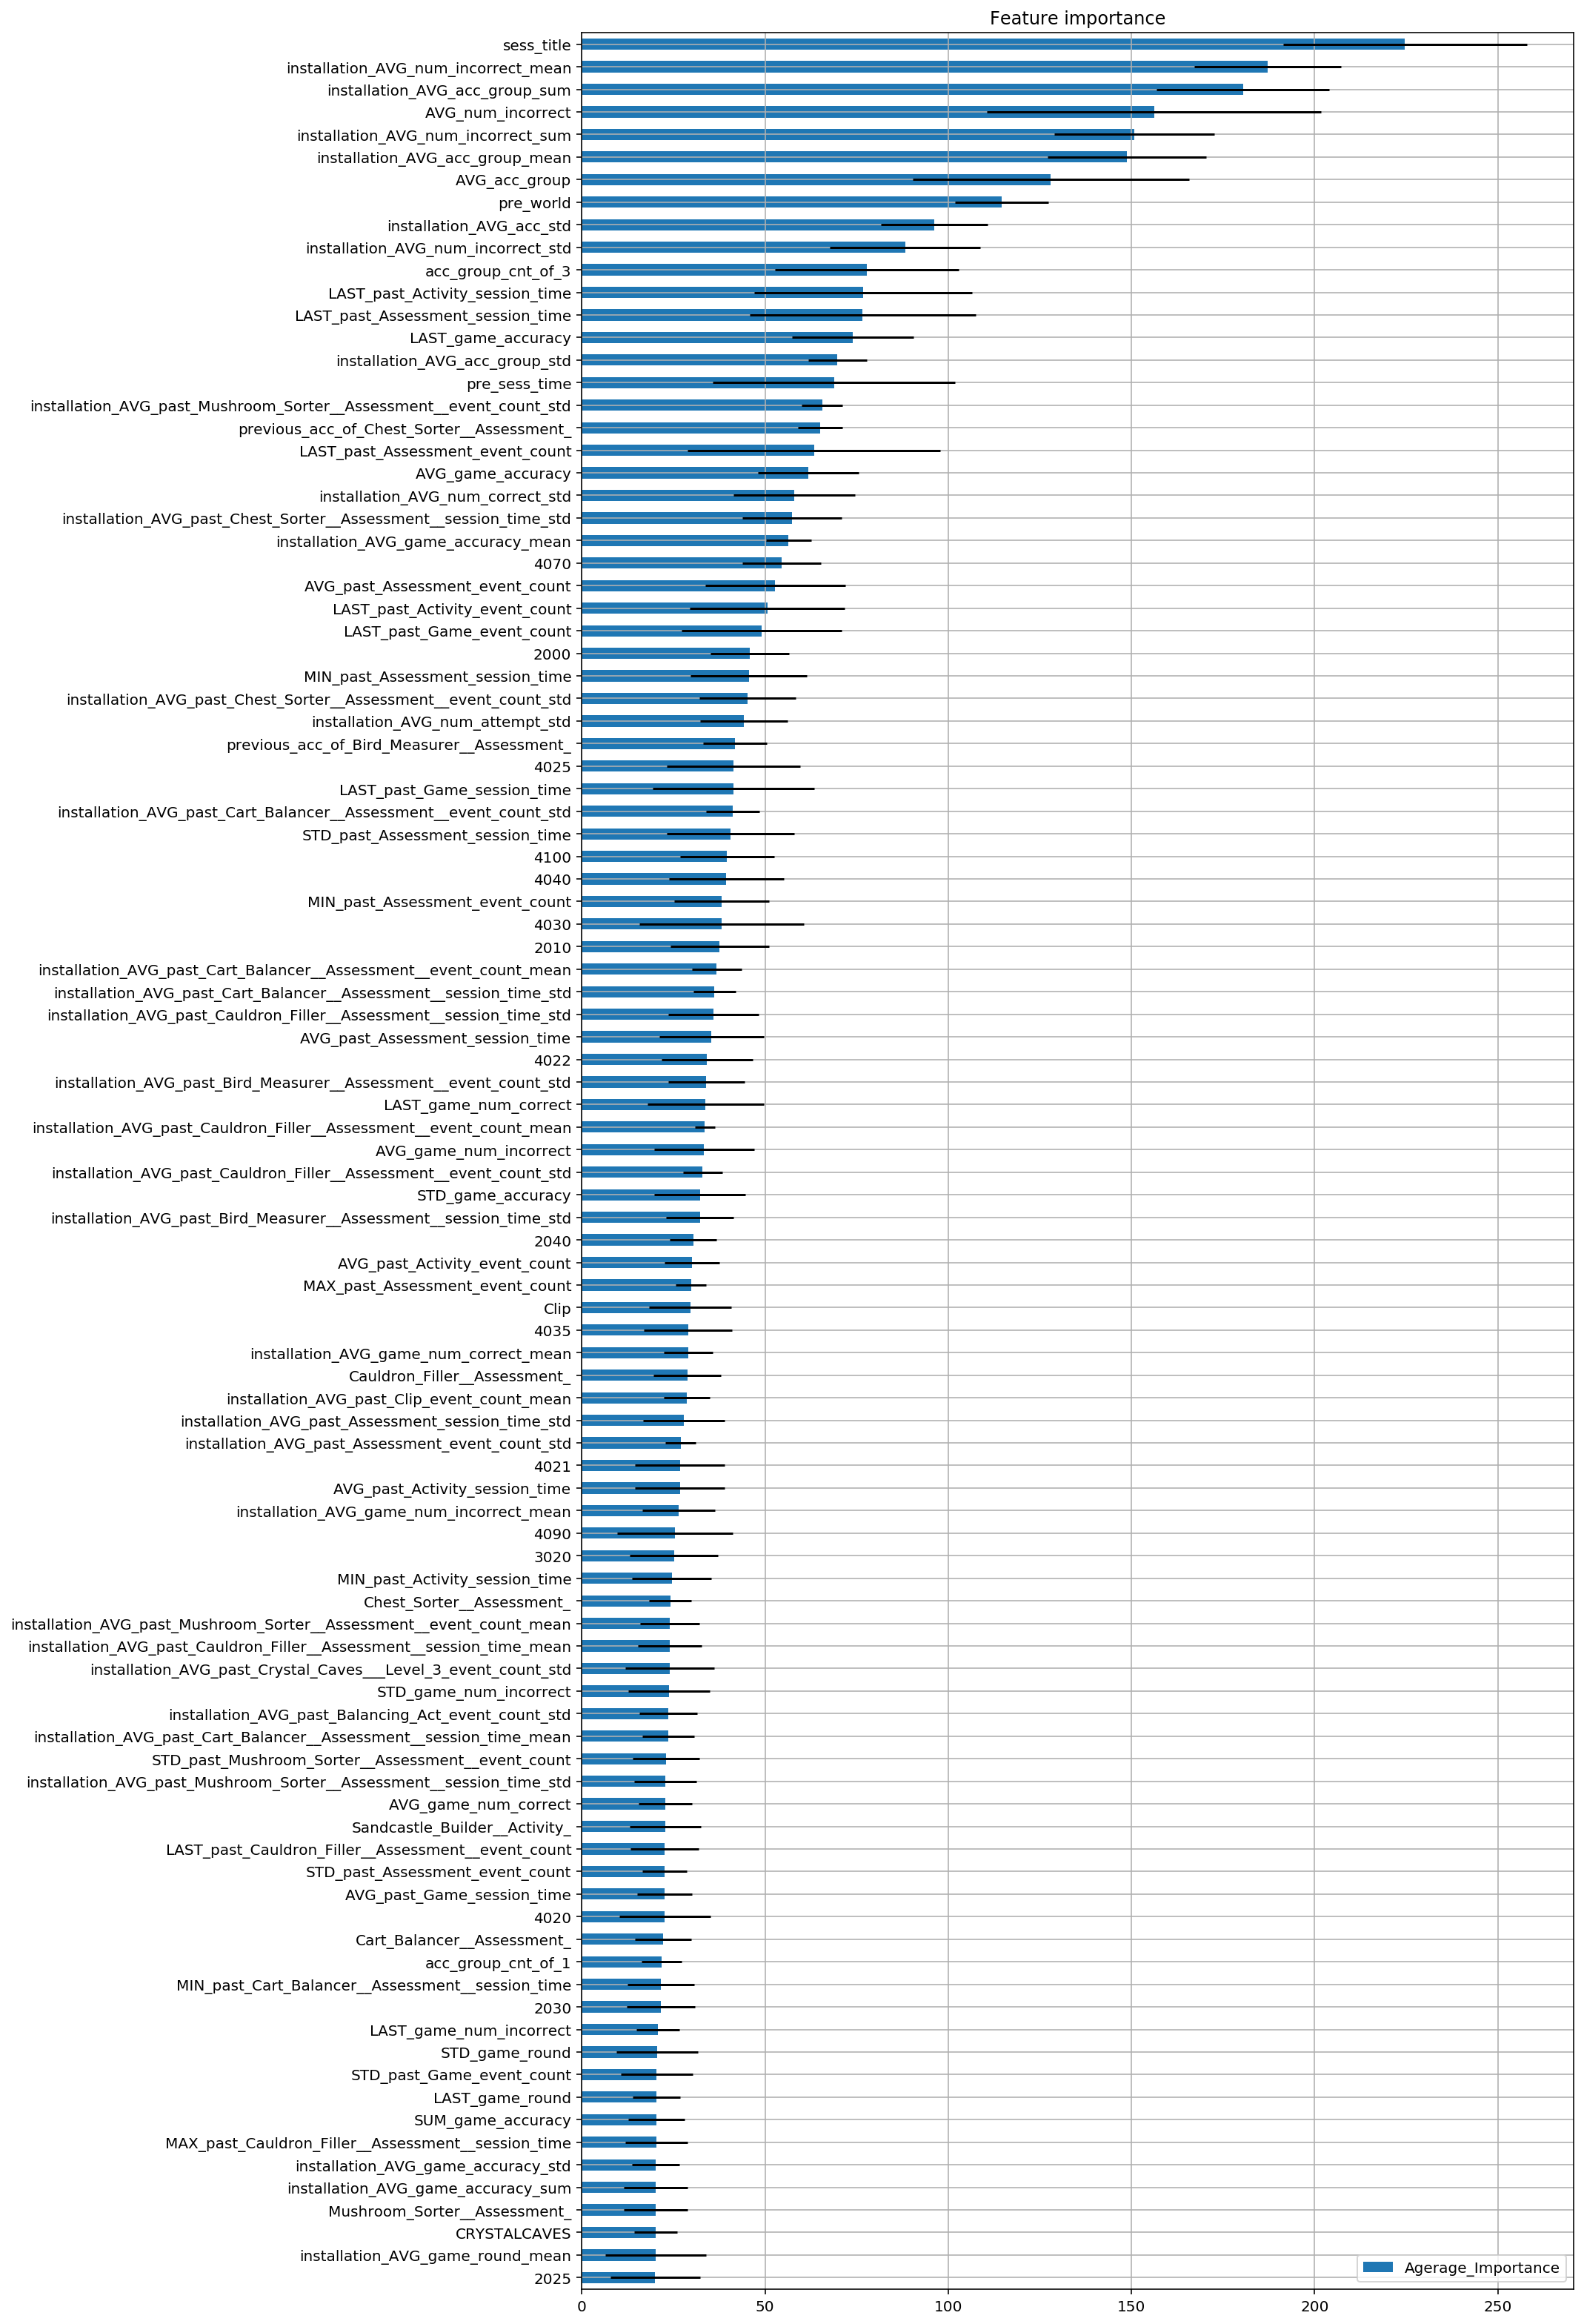

In [26]:
lgb_model.plot_importance(lgb_model.models, max_num_features=100, figsize=(12, 28))

## Model Evaluation

In [27]:
final_pred = lgb_model.y_pred
trian_pred = lgb_model.oof_pred

optR = OptimizedRounder(num_class=4)
optR.fit(trian_pred, reduced_train['accuracy_group'])
opt_preds = optR.predict(trian_pred)

sub_preds = optR.predict(final_pred)

print(final_pred.shape)

(1000,)


In [28]:
rmse_score = np.sqrt(mean_squared_error(reduced_train['accuracy_group'], lgb_model.oof_pred))
print(f'RMSE: {rmse_score}')

off_score = qwk3(reduced_train['accuracy_group'], opt_preds)
print(f'OOF: {off_score}')

print(f'coefficients: {optR.coefficients()}')

RMSE: 0.9029629999304362
OOF: 0.6795903580773901
coefficients: [1.04278176 1.63864986 2.21727518]


In [29]:
def eval_with_truncated_data(y_pred, y_true, groups, n_trials=10):
    eval_result = {}
    trials = []
    gp_idx_df = pd.DataFrame({"groups": groups, "index": np.arange(len(y_pred))})
    
    dice_results = []
    for _, df in gp_idx_df.groupby("groups"):
        dice_result = np.random.choice(df["index"], size=n_trials)
        dice_results.append(dice_result)

    idx_choice = np.vstack(dice_results)
    for i in range(n_trials):
        y_pred_choice = y_pred[idx_choice[:, i]]
        y_true_choice = y_true[idx_choice[:, i]]
        trials.append(qwk3(y_true_choice, y_pred_choice))

    mean_score = np.mean(trials)
    median_score = np.median(trials)
    std = np.std(trials)
    eval_result["mean"] = mean_score
    eval_result["median"] = median_score
    eval_result["all_trials"] = trials
    eval_result["0.95lower_bound"] = mean_score - 2 * std
    eval_result["0.95upper_bound"] = mean_score + 2 * std
    eval_result["std"] = std
    return eval_result

truncated_score = eval_with_truncated_data(opt_preds, reduced_train['accuracy_group'], reduced_train['installation_id'])

print(f"Truncated OOF QWK: {truncated_score['mean']:.4f}")
print(f"Truncated OOF QWK median: {truncated_score['median']:.4f}")
print(f"Truncated OOF QWK 0.95 upper: {truncated_score['0.95upper_bound']:.4f}")
print(f"Truncated OOF QWK 0.95 lower: {truncated_score['0.95lower_bound']:.4f}")
print(f"Truncated OOF QWK std: {truncated_score['std']:.4f}")

Truncated OOF QWK: 0.6643
Truncated OOF QWK median: 0.6631
Truncated OOF QWK 0.95 upper: 0.6723
Truncated OOF QWK 0.95 lower: 0.6562
Truncated OOF QWK std: 0.0040


OOF: 0.6795903580773901
Truncated OOF QWK: 0.6643


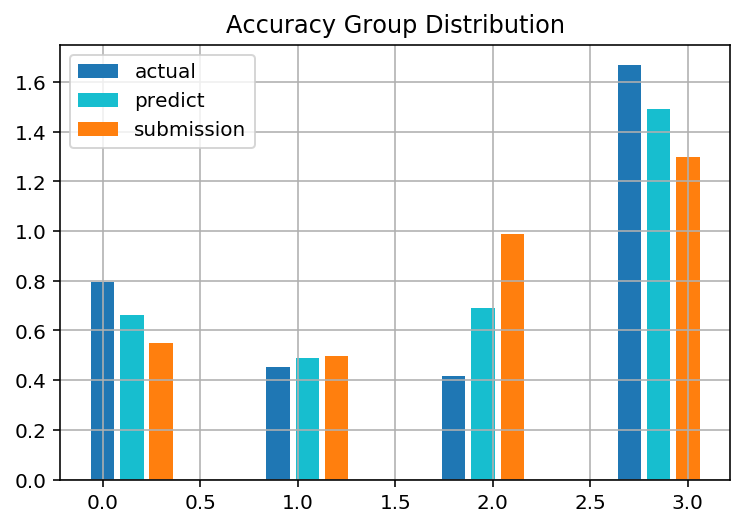

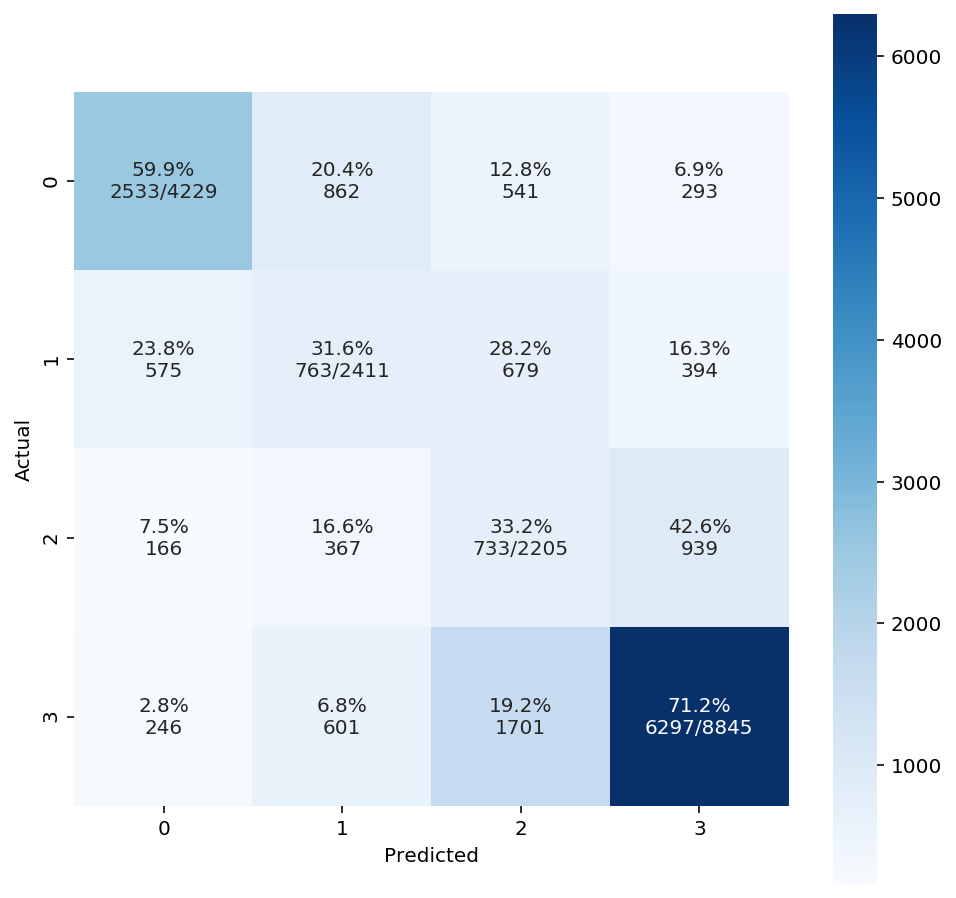

In [30]:
print(f'OOF: {off_score}')
print(f"Truncated OOF QWK: {truncated_score['mean']:.4f}")

def plot_cm(y_true, y_pred, figsize=(8, 8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap=plt.cm.Blues, square=True, annot=annot, fmt='', ax=ax)


plt.title('Accuracy Group Distribution')
reduced_train['accuracy_group'].hist(align='left', rwidth=0.4, normed=True, color='tab:blue', label='actual')
pd.Series(opt_preds).hist(align='mid', rwidth=0.4, normed=True, color='tab:cyan', label='predict')
pd.Series(sub_preds).hist(align='right', rwidth=0.4, normed=True, color='tab:orange', label='submission')
plt.legend()
plt.show()

plot_cm(reduced_train['accuracy_group'], opt_preds)

## Submission

In [31]:
sample_submission['accuracy_group'] = sub_preds
display(sample_submission['accuracy_group'].value_counts(normalize=True).sort_index())

if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
    sample_submission.to_csv('submission.csv', index=False)

0    0.165
1    0.149
2    0.296
3    0.390
Name: accuracy_group, dtype: float64